# Fermi-Hubbard Dynamics on a Quantum Circuit

**2-site, 4-qubit simulation of Fermi-Hubbard dynamics using Jordan-Wigner encoding and Trotterized time evolution in Cirq.**

This notebook implements a simple quantum circuit simulation of the Fermi-Hubbard model. A single electron state is first prepared to verify the system works as expected. A double-occupied state is then perpared to simulate quench dynamics, observing the evolution of the Hamiltonian as kinetic delocalisation and coulombic repulsion compete across different interaction strengths.

The objective of this project was to build upon my own understanding of how quantum systems may be simulated

## The Fermi-Hubbard Model

The Fermi-Hubbard model describes electrons moving in a lattice. In this instance we are setting up a minimal quantum material: two atomic sites electrons can hop between via tunelling, repelling each other when sharing a site.

The Fermi-Hubbard Hamiltonian on a 2-site lattice is given:

$$H = -t \sum_{\sigma} \left( c^\dagger_{0\sigma} c_{1\sigma} + c^\dagger_{1\sigma} c_{0\sigma} \right) + U \sum_{i} n_{i\uparrow} n_{i\downarrow}$$

where $t$ is the hopping amplitude and $U$ is the on-site Coulomb repulsion. The ratio $U/t$ controls the balance between kinetic energy (delocalisation) and interaction energy (localisation).

## Jordan-Wigner Encoding

In this experiment the system we are investigating describes electrons, which are fermions. To simulate fermionic operators on a quantum computer, we map fermionic creation/annihilation operators to Pauli operators using the Jordan-Wigner transformation. This is a necessary step in our simulation. It is not possible to simply map our fermions directly to qubits - fermions are antisymmetric under exchange, so when two electrons swap sites they produce a minus sign.

For our 2-site system with spin-up and spin-down electrons we use 4 qubits for 4 spin-orbitals:

| Qubit | Spin-orbital |
|-------|-------------|
| $q_0$ | Site 0, spin-$\uparrow$ |
| $q_1$ | Site 0, spin-$\downarrow$ |
| $q_2$ | Site 1, spin-$\uparrow$ |
| $q_3$ | Site 1, spin-$\downarrow$ |

Under Jordan-Wigner, the hopping terms acquire Z-strings to enforce fermionic anticommutation.

## Single Electron Verification

### Constructing the Hamiltonian

We build the Hamiltonian as a list of `(coefficient, PauliString)` tuples. Each term in the Fermi-Hubbard Hamiltonian maps to one or more Pauli strings via the Jordan-Wigner transformation:

- **Hopping terms** ($-t$): Each spin species contributes two Pauli strings with three-body operators and Z-strings enforcing fermionic antisymmetry.
- **Interaction terms** ($U$): The number operator $n_{i\sigma} = \frac{1}{2}(I - Z_i)$ means each on-site repulsion term $U \, n_{i\uparrow} n_{i\downarrow}$ expands into single-$Z$ and $ZZ$ terms.

In [6]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

In [7]:
qubits = cirq.LineQubit.range(4)

def build_hamiltonian(t_hop, U_int):
    q = cirq.LineQubit.range(4)
    terms = []

    # spin-up hopping: site 0 <-> site 1 (qubits 0, 2 with Z-string on qubit 1)
    terms.append((-t_hop / 2, cirq.X(q[0]) * cirq.Z(q[1]) * cirq.X(q[2])))
    terms.append((-t_hop / 2, cirq.Y(q[0]) * cirq.Z(q[1]) * cirq.Y(q[2])))

    # spin-down hopping: site 0 <-> site 1 (qubits 1, 3 with Z-string on qubit 2)
    terms.append((-t_hop / 2, cirq.X(q[1]) * cirq.Z(q[2]) * cirq.X(q[3])))
    terms.append((-t_hop / 2, cirq.Y(q[1]) * cirq.Z(q[2]) * cirq.Y(q[3])))

    # on-site repulsion at site 0 (qubits 0 and 1)
    terms.append((-U_int / 4, cirq.Z(q[0])))
    terms.append((-U_int / 4, cirq.Z(q[1])))
    terms.append(( U_int / 4, cirq.Z(q[0]) * cirq.Z(q[1])))

    # on-site repulsion at site 1 (qubits 2 and 3)
    terms.append((-U_int / 4, cirq.Z(q[2])))
    terms.append((-U_int / 4, cirq.Z(q[3])))
    terms.append(( U_int / 4, cirq.Z(q[2]) * cirq.Z(q[3])))

    return terms

### Trotterized Time Evolution

To simulate time evolution $e^{-iHt}$, we use a first-order Trotter decomposition. The Hamiltonian is a sum of non-commuting terms, so we cannot exponentiate it directly. Instead, we approximate:

$$e^{-iH\Delta t} \approx \prod_k e^{-i h_k \Delta t}$$

where each $h_k$ is a single Pauli string term. Cirq's `PauliStringPhasor` implements $e^{-i\theta P}$ for a Pauli string $P$, which handles the circuit decomposition for us. The approximation improves as $\Delta t \to 0$.

In [9]:
def trotter_step(hamiltonian, dt):
    circuit = cirq.Circuit()
    for coeff, pauli_string in hamiltonian:
        theta = coeff * dt
        circuit.append(cirq.PauliStringPhasor(
            pauli_string,
            exponent_neg=theta / np.pi,
            exponent_pos=-theta / np.pi
        ))
    return circuit

### Initial State and Simulation

We prepare a single spin-up electron localised on site 0 by applying an $X$ gate to qubit 0 (flipping $|0\rangle \to |1\rangle$, i.e. creating an electron in that spin-orbital). All other qubits remain in $|0\rangle$ (empty).

The simulation applies repeated Trotter steps and extracts the probability of finding the electron on site 0 at each time step. For 4 qubits, the state vector has $2^4 = 16$ amplitudes. Qubit 0 (site 0, spin-up) is the most significant bit, so basis states $|1\text{XXX}\rangle$ - indices 8 through 15 - correspond to the electron being on site 0.

In [11]:
def single_electron_initial_state():
    q = cirq.LineQubit.range(4)
    circuit = cirq.Circuit()
    circuit.append(cirq.X(q[0]))  # spin-up electron on site 0
    return circuit

def run_single_electron(t_hop, U_int, total_time, n_steps):
    dt = total_time / n_steps
    hamiltonian = build_hamiltonian(t_hop, U_int)
    one_step = trotter_step(hamiltonian, dt)
    simulator = cirq.Simulator()

    times = []
    occupations = []

    for step in range(n_steps + 1):
        circuit = single_electron_initial_state()
        if step > 0:
            circuit += one_step * step

        result = simulator.simulate(circuit, qubit_order=cirq.LineQubit.range(4))
        probs = np.abs(result.final_state_vector) ** 2

        # qubit 0 is the MSB: indices 8-15 have qubit 0 = |1⟩
        n0_up = np.sum(probs[8:])

        times.append(step * dt)
        occupations.append(n0_up)

    return times, occupations

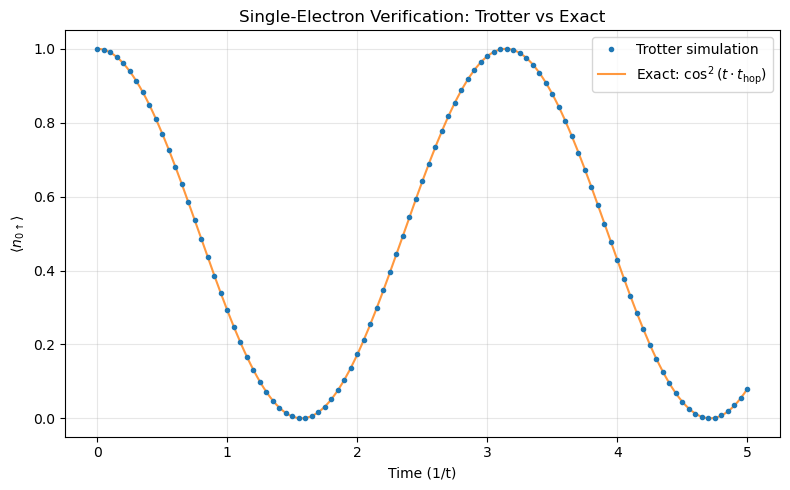

Max deviation from exact: 0.000000


In [12]:
# run simulation with U=0 (free hopping) to compare against analytical solution
t_hop = 1.0
times, occupations = run_single_electron(t_hop=t_hop, U_int=0.0, total_time=5.0, n_steps=100)

# analytical solution: site-0 occupation oscillates as cos²(t * t_hop)
analytical_times = np.linspace(0, 5.0, 200)
analytical_occupation = np.cos(analytical_times * t_hop) ** 2

plt.figure(figsize=(8, 5))
plt.plot(times, occupations, 'o', markersize=3, label='Trotter simulation', zorder=5)
plt.plot(analytical_times, analytical_occupation, '-', label=r'Exact: $\cos^2(t \cdot t_{\mathrm{hop}})$', alpha=0.8)
plt.xlabel('Time (1/t)')
plt.ylabel(r'$\langle n_{0\uparrow} \rangle$')
plt.title('Single-Electron Verification: Trotter vs Exact')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Max deviation from exact: {max(abs(np.array(occupations) - np.cos(np.array(times) * t_hop)**2)):.6f}")

### Verification

A single electron hopping between two sites is a two-level system with effective Hamiltonian $-t \, \sigma_x$. Time evolution gives $|\psi(t)\rangle = \cos(t \cdot t_{\text{hop}})|0\rangle + i\sin(t \cdot t_{\text{hop}})|1\rangle$, so the site-0 occupation is $\cos^2(t \cdot t_{\text{hop}})$.

With only one electron and $U=0$, the only active terms are the two spin-up hopping Pauli strings, which commute with each other. The Trotter decomposition is therefore exact, this test confirms correctness of our encoding.

## Two-Electron Dynamics

With the single-electron case verified, we now prepare the physically interesting state: both a spin-up and spin-down electron localised on site 0. This is a doubly-occupied state, and the on-site repulsion $U$ is now active.

The system is prepared in this localised state and then allowed to evolve under the full Hamiltonian. The competition between kinetic energy (which favours delocalisation) and interaction energy (which penalises double occupancy) produces dynamics that depend strongly on the ratio $U/t$.

### Initial State and Observables

The initial state now has both a spin-up and spin-down electron on site 0, prepared by applying $X$ gates to qubits 0 and 1. This gives the state $|1100\rangle$ in the computational basis.

With two electrons, we track three observables:

- **$\langle n_{0\uparrow} \rangle$**: probability that the spin-up electron is on site 0.
- **$\langle n_{0\downarrow} \rangle$**: probability that the spin-down electron is on site 0.
- **$\langle n_{0\uparrow} n_{0\downarrow} \rangle$**: probability that both electrons are on site 0 simultaneously (double occupancy).

These are extracted from the 16-element state vector using bitwise masks. In Cirq's ordering, qubit 0 is the most significant bit, so $q_0 = 1$ corresponds to bit 3 being set (`0b1000`) and $q_1 = 1$ to bit 2 (`0b0100`). Double occupancy requires both bits set (`0b1100`).

In [16]:
def two_electron_initial_state():
    q = cirq.LineQubit.range(4)
    circuit = cirq.Circuit()
    circuit.append(cirq.X(q[0]))  # spin-up electron on site 0
    circuit.append(cirq.X(q[1]))  # spin-down electron on site 0
    return circuit

def run_two_electron(t_hop, U_int, total_time, n_steps):
    dt = total_time / n_steps
    hamiltonian = build_hamiltonian(t_hop, U_int)
    one_step = trotter_step(hamiltonian, dt)
    simulator = cirq.Simulator()

    times = []
    n0_up_list = []
    n0_down_list = []
    double_occ_list = []

    for step in range(n_steps + 1):
        circuit = two_electron_initial_state()
        if step > 0:
            circuit += one_step * step

        result = simulator.simulate(circuit, qubit_order=cirq.LineQubit.range(4))
        probs = np.abs(result.final_state_vector) ** 2

        # bitwise extraction from 4-qubit state vector (MSB = q0)
        # q0 = bit 3, q1 = bit 2, q2 = bit 1, q3 = bit 0
        n0_up = sum(probs[i] for i in range(16) if i & 0b1000)
        n0_down = sum(probs[i] for i in range(16) if i & 0b0100)
        double_occ = sum(probs[i] for i in range(16) if (i & 0b1100) == 0b1100)

        times.append(step * dt)
        n0_up_list.append(n0_up)
        n0_down_list.append(n0_down)
        double_occ_list.append(double_occ)

    return times, n0_up_list, n0_down_list, double_occ_list

### Dynamics Across Interaction Strengths

We run the simulation at fixed $t_{\text{hop}} = 1$ for several values of $U/t$, from the non-interacting limit ($U=0$) through to the strongly correlated regime ($U/t = 8$). We expect that as $U/t$ increases, the electrons become increasingly reluctant to share a site, suppressing charge transfer and preserving double occupancy on the initial site.

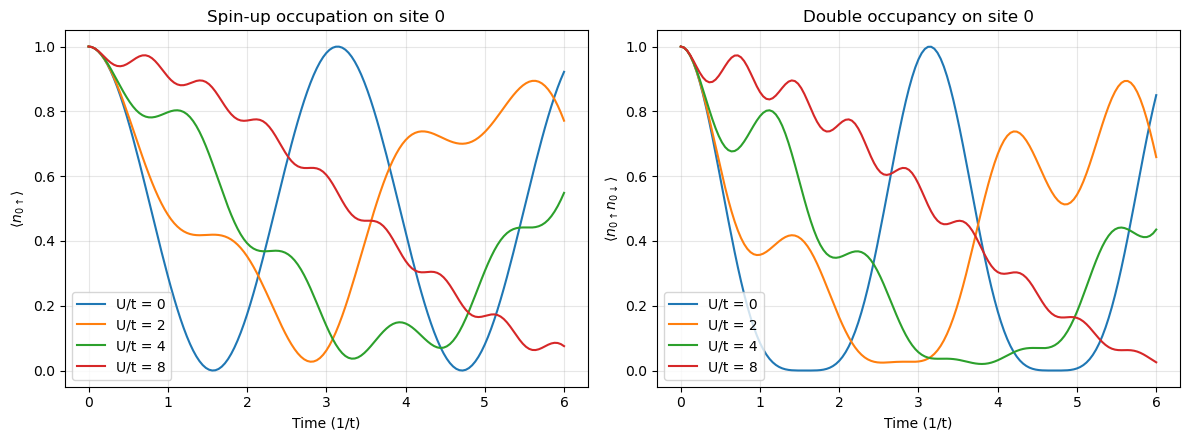

In [18]:
t_hop = 1.0
U_values = [0.0, 2.0, 4.0, 8.0]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
total_time = 6.0
n_steps = 150

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

for U, color in zip(U_values, colors):
    times, n0_up, n0_down, double_occ = run_two_electron(
        t_hop=t_hop, U_int=U, total_time=total_time, n_steps=n_steps
    )
    label = f'U/t = {U/t_hop:.0f}'
    axes[0].plot(times, n0_up, '-', color=color, linewidth=1.5, label=label)
    axes[1].plot(times, double_occ, '-', color=color, linewidth=1.5, label=label)

axes[0].set_xlabel('Time (1/t)')
axes[0].set_ylabel(r'$\langle n_{0\uparrow} \rangle$')
axes[0].set_title('Spin-up occupation on site 0')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Time (1/t)')
axes[1].set_ylabel(r'$\langle n_{0\uparrow} n_{0\downarrow} \rangle$')
axes[1].set_title('Double occupancy on site 0')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Discussion

The two panels show the expected physics of the two-site dual occupancy Fermi-Hubbard system:

At $U/t = 0$, the electrons hop freely and independently. The spin-up occupation oscillates fully between sites, and double occupancy tracks this oscillation since there is no energy penalty for sharing a site.

As $U/t$ increases, the on-site repulsion makes double occupancy energetically costly. At $U/t = 8$, the electrons are largely frozen in place, the system is deep in the Mott-insulating regime where interaction energy dominates over kinetic energy.

This system still sits within the classical limit for computation - it serves as a simplified example of the kinds of simulation that can be made possible on a quantum chip, demonstrating the circuit construction and research pipeline that would transfer to hardware at scales where classical simulation would become infeasible.